## Question 5
- Count the number of black people convicted of felonies vs. white people convicted of misdemeanors (or not convicted at all) for the same offense by year

**Issues:**
- Try throwing in all races (just for funsies, it’s ok if it’s long)
- Maybe do like top 5 codeSections instead of the overall

In [1]:
import io
import os
import requests
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
import matplotlib as plt
import seaborn as sns

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-f4edz6dx because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
infile = 'Data/circuit_criminal_2019_withDescriptions.csv'
spark = SparkSession \
    .builder \
    .appName("Criminal Expungement") \
    .getOrCreate()
circuit = spark.read.csv(infile, inferSchema=True, header = True)
circuit.createOrReplaceTempView('df')

In [10]:
df_chargetype = spark.sql(
'''
SELECT DispositionCode, CodeSection, code_and_desc, ChargeType, df.Race, count(DispositionCode) AS RCount, Total FROM df
INNER JOIN (
    SELECT Race, count(Race) as Total FROM df
    GROUP BY Race) c ON c.Race = df.Race
WHERE (DispositionCode = 'Guilty') 
AND (ChargeType = 'Misdemeanor' OR ChargeType = 'Felony')
AND (CodeSection = '19.2-306' OR CodeSection = '18.2-250' OR CodeSection = '18.2-248' OR CodeSection = '18.2-172' OR CodeSection = '18.2-95')
AND (df.Race = 'White' OR df.Race = 'Black')
GROUP BY DispositionCode, df.Race, Total, ChargeType, CodeSection, code_and_desc
ORDER BY CodeSection
'''
)
df_chargetype = df_chargetype.withColumn('Percentage',df_chargetype.RCount*100/df_chargetype.Total).select('ChargeType',
                                                                                                           'code_and_desc',
                                                                                                           'Race',
                                                                                                           'Percentage',
                                                                                                           'Total')

In [11]:
df = df_chargetype.toPandas()
df

,ChargeType,code_and_desc,Race,Percentage,Total
0,Felony,"18.2-172, FORGERY",Black,0.699063,32329
1,Felony,"18.2-172, FORGERY",White,0.950449,43874
2,Felony,"18.2-248, MANUF/ETC CONTROLLED SUBSTANCE",Black,2.935445,32329
3,Felony,"18.2-248, MANUF/ETC CONTROLLED SUBSTANCE",White,2.846789,43874
4,Misdemeanor,"18.2-248, MANUF/ETC CONTROLLED SUBSTANCE",White,0.020513,43874
5,Felony,"18.2-250, POSS.OF CONTROLLED SUBSTANCE",Black,3.049893,32329
6,Felony,"18.2-250, POSS.OF CONTROLLED SUBSTANCE",White,5.153394,43874
7,Misdemeanor,"18.2-250, POSS.OF CONTROLLED SUBSTANCE",Black,0.046398,32329
8,Misdemeanor,"18.2-250, POSS.OF CONTROLLED SUBSTANCE",White,0.166386,43874
9,Felony,"18.2-95, GRAND LARCENY",White,1.953321,43874


In [12]:
df['Charge and Race'] = df['ChargeType'] + " - " + df['Race']

In [13]:
def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() *  (2/3)
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


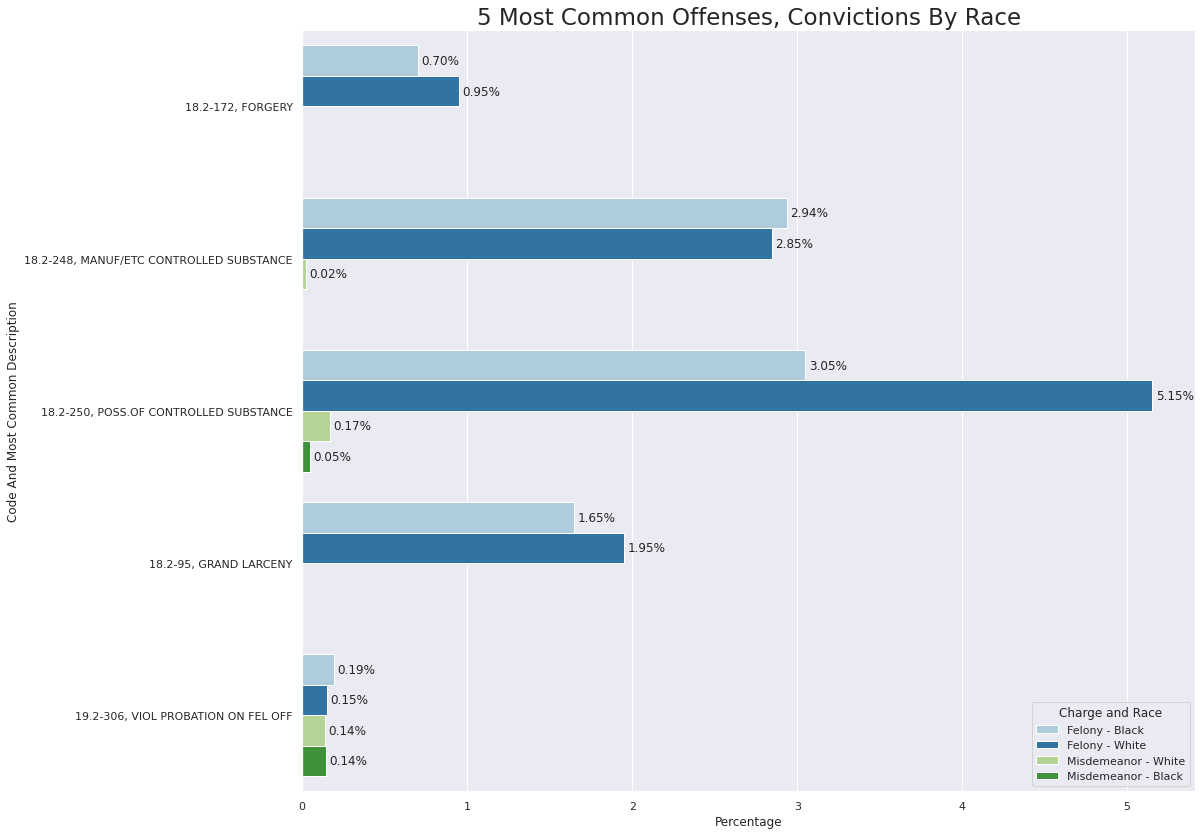

In [14]:
sns.set(rc={'figure.figsize':(16,14)})
sns.set(style="darkgrid")
sns.set_palette("Paired")
ax = sns.barplot(y="code_and_desc",
                 x="Percentage",
                 data=df, 
                 hue="Charge and Race")
ax.set(xlabel='Percentage', ylabel='Code And Most Common Description')
ax.set_title('5 Most Common Offenses, Convictions By Race', fontsize = 23)
for p in ax.patches:
    width = p.get_width()                   # get bar length
    ax.text(width + .02,                    # set the text at 1 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:1.2f}%'.format(width),        # set variable to display, 2 decimals
            ha = 'left',                    # horizontal alignment
            va = 'center')                  # vertical alignment